In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scipy.io
from sklearn import preprocessing
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms

In [2]:
# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


In [3]:
# Initialize variables required for the algorithm

learning_rate = 2e-2    # initial learning rate
Kx = 10
Ky = 10
n_hidden = 2000         # number of hidden units in hidden layer
mu = 0.0                # mean for gaussian distribution to initialize weights with
sigma = 1.0             # standard deviation for gaussian distribution to initialize weights with
n_epochs = 200          # number of epochs
batch_size = 100        # size of the minibatch
precision = 1e-30       # parameter to control numerical precision of weight updates
anti_hebbian_learning_strength = 0.4    # Strength of the anti-hebbian learning
lebesgue_norm = 2.0                     # Lebesgue norm of the weights
rank = 2                                # ranking parameter, must be integer that is bigger or equal than 2

In [4]:
# UNSUPERVISED 'BIO' LEARNING ALGORITHM

# Define function that performs the unsupervised learning and returns weights
# that correspond to feature detectors.
# Uses cuda if available.
def get_unsupervised_weights(data, n_hidden, n_epochs, batch_size, learning_rate, precision, 
                             anti_hebbian_learning_strength, lebesgue_norm, rank):
    print("Starting unsupervised bio-plausible training")
    
    num_samples = data.shape[0]   # Number of samples/images.
    num_features = data.shape[1]  # Number of pixels for each sample/image.
    
    # Initialize weights to be values drawn from gaussian distribution.
    synapses = np.random.normal(mu, sigma, (n_hidden, num_features)).astype(np.float32)
    weights = torch.from_numpy(synapses).to(device)

    # The external loop runs over epochs
    for epoch in range(n_epochs):
        eps = learning_rate * (1 - epoch / n_epochs)

        # Scramble the images and values. So that when making a
        # mini batch, random values/images will be chosen on each iteration.
        random_permutation_samples = np.random.permutation(num_samples)
        shuffled_epoch_data = data[random_permutation_samples,:]

        # Internal loop runs over minibatches    
        for i in range(num_samples // batch_size):        
            # For every minibatch the overlap with the data (tot_input) is 
            # calculated for each data point and each hidden unit.
            mini_batch = shuffled_epoch_data[i*batch_size:(i+1)*batch_size,:].astype(np.float32)
            mini_batch = torch.from_numpy(mini_batch).to(device)           
            mini_batch = torch.transpose(mini_batch, 0, 1)

            sign = torch.sign(weights)            
            W = sign * torch.abs(weights) ** (lebesgue_norm - 1)    
            # https://stackoverflow.com/questions/44524901/how-to-do-product-of-matrices-in-pytorch
            tot_input_torch = torch.mm(W, mini_batch)

            # The sorted strengths of the activations are stored in y. 
            # The variable yl stores the activations of the post synaptic cells - 
            # it is denoted by g(Q) in Eq 3 of 'Unsupervised Learning by Competing Hidden Units', see also Eq 9 and Eq 10.        
            y_torch = torch.argsort(tot_input_torch, dim=0)            
            yl_torch = torch.zeros((n_hidden, batch_size), dtype = torch.float).to(device)
            yl_torch[y_torch[n_hidden-1,:], torch.arange(batch_size)] = 1.0
            yl_torch[y_torch[n_hidden-rank], torch.arange(batch_size)] = -anti_hebbian_learning_strength

            # The variable ds is the right hand side of Eq 3        
            xx_torch = torch.sum(yl_torch * tot_input_torch,1)  
            xx_torch = xx_torch.unsqueeze(1)                    
            xx_torch = xx_torch.repeat(1, num_features)
            ds_torch = torch.mm(yl_torch, torch.transpose(mini_batch, 0, 1)) - (xx_torch * weights)

            # Update weights
            # The weights are updated after each minibatch in a way so that the largest update 
            # is equal to the learning rate eps at that epoch.        
            nc_torch = torch.max(torch.abs(ds_torch))
            if nc_torch < precision: 
                nc_torch = precision            
            weights += eps*(ds_torch/nc_torch)

            #if (i+1) % 100 == 0:
            #    print (f'Epoch [{epoch+1}/{n_epochs}], Step [{i+1}/{num_samples // batch_size}]')

        print (f'Epoch [{epoch+1}/{n_epochs}]')
        
    print("Completed unsupervised bio-plausible training")
    return weights
    #return weights.cpu().numpy()


In [5]:
# LOAD AND PREPARE MNIST DATA FOR UNSUPERVISED TRAINING

print("Loading MNIST...")
mat = scipy.io.loadmat('mnist_all.mat')
print("Done loading MNIST")
#print(mat)

Nc=10 # number of classes
N=784 # number of pixels for each image. 28x28

M=np.zeros((0,N))
for i in range(Nc):
    M=np.concatenate((M, mat['train'+str(i)]), axis=0)
M=M/255.0

data_mnist = M
print(f'Number of samples: {data_mnist.shape[0]}')
print(f'Number of features: {data_mnist.shape[1]}')

Loading MNIST...
Done loading MNIST
Number of samples: 60000
Number of features: 784


In [6]:
# RUN UNSUPERVISED 'BIO' LEARNING ALGORITHM for MNIST

# Calculates weights for data and provided number of hidden units (given other configuration)
weights_mnist = get_unsupervised_weights(data_mnist, n_hidden, n_epochs, batch_size, learning_rate, precision, 
                                         anti_hebbian_learning_strength, lebesgue_norm, rank)
#print(weights_mnist.shape)
#print(weights_mnist)

# Keep backups of these weights
weights_mnist_backup = weights_mnist
weights_mnist_frozen = weights_mnist

# TODO Maybe write these to file to keep?

Starting unsupervised bio-plausible training
Epoch [1/200]
Epoch [2/200]
Epoch [3/200]
Epoch [4/200]
Epoch [5/200]
Epoch [6/200]
Epoch [7/200]
Epoch [8/200]
Epoch [9/200]
Epoch [10/200]
Epoch [11/200]
Epoch [12/200]
Epoch [13/200]
Epoch [14/200]
Epoch [15/200]
Epoch [16/200]
Epoch [17/200]
Epoch [18/200]
Epoch [19/200]
Epoch [20/200]
Epoch [21/200]
Epoch [22/200]
Epoch [23/200]
Epoch [24/200]
Epoch [25/200]
Epoch [26/200]
Epoch [27/200]
Epoch [28/200]
Epoch [29/200]
Epoch [30/200]
Epoch [31/200]
Epoch [32/200]
Epoch [33/200]
Epoch [34/200]
Epoch [35/200]
Epoch [36/200]
Epoch [37/200]
Epoch [38/200]
Epoch [39/200]
Epoch [40/200]
Epoch [41/200]
Epoch [42/200]
Epoch [43/200]
Epoch [44/200]
Epoch [45/200]
Epoch [46/200]
Epoch [47/200]
Epoch [48/200]
Epoch [49/200]
Epoch [50/200]
Epoch [51/200]
Epoch [52/200]
Epoch [53/200]
Epoch [54/200]
Epoch [55/200]
Epoch [56/200]
Epoch [57/200]
Epoch [58/200]
Epoch [59/200]
Epoch [60/200]
Epoch [61/200]
Epoch [62/200]
Epoch [63/200]
Epoch [64/200]
Epoc

In [7]:
# SANITY CHECKS (for my sanity)

print(weights_mnist)
print()
print(weights_mnist_backup)
print()
print(weights_mnist_frozen)
print()

print(torch.all(weights_mnist.eq(weights_mnist_backup)))
print(torch.all(weights_mnist.eq(weights_mnist_frozen)))
print(torch.all(weights_mnist_frozen.eq(weights_mnist_backup)))

#print((weights_mnist==weights_mnist_backup).all())
#print((weights_mnist_frozen==weights_mnist_backup).all())

tensor([[-9.8091e-45, -9.8091e-45, -9.8091e-45,  ...,  9.8091e-45,
          9.8091e-45,  9.8091e-45],
        [ 2.8026e-45,  2.8026e-45, -2.8026e-45,  ...,  2.8026e-45,
         -2.8026e-45,  2.8026e-45],
        [ 9.8091e-45,  9.8091e-45, -9.8091e-45,  ...,  9.8091e-45,
         -9.8091e-45,  9.8091e-45],
        ...,
        [-2.8026e-45,  2.8026e-45, -2.8026e-45,  ...,  2.8026e-45,
         -2.8026e-45,  2.8026e-45],
        [-9.5290e-09,  1.4833e-09, -5.4322e-09,  ..., -1.2896e-08,
          1.7012e-09,  7.3501e-09],
        [-7.0065e-45,  7.0065e-45, -7.0065e-45,  ...,  7.0065e-45,
         -7.0065e-45, -7.0065e-45]], device='cuda:0')

tensor([[-9.8091e-45, -9.8091e-45, -9.8091e-45,  ...,  9.8091e-45,
          9.8091e-45,  9.8091e-45],
        [ 2.8026e-45,  2.8026e-45, -2.8026e-45,  ...,  2.8026e-45,
         -2.8026e-45,  2.8026e-45],
        [ 9.8091e-45,  9.8091e-45, -9.8091e-45,  ...,  9.8091e-45,
         -9.8091e-45,  9.8091e-45],
        ...,
        [-2.8026e-45,  2.802

<IPython.core.display.Javascript object>


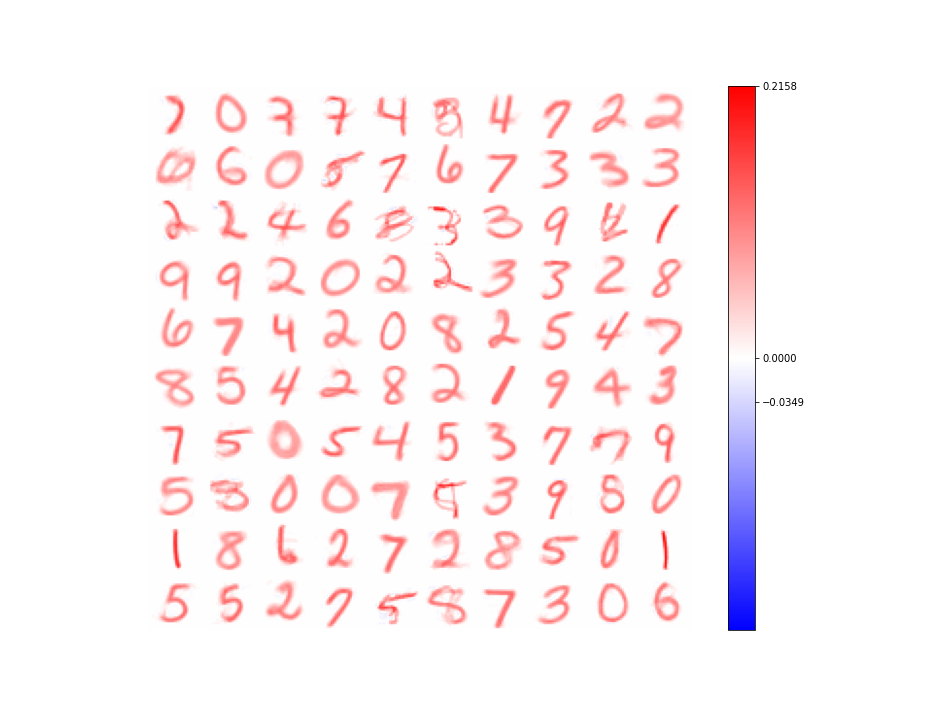

torch.Size([2000, 784])
Fin


In [8]:
# Draw MNIST weights/feature detectors generated by unsupervised bio algo

# REFERENCED FROM: https://github.com/DimaKrotov/Biological_Learning
# To draw a heatmap of the weights a helper function is created

def draw_weights(synapses, Kx, Ky):
    yy=0
    HM=np.zeros((28*Ky,28*Kx))
    for y in range(Ky):
        for x in range(Kx):            
            HM[y*28:(y+1)*28,x*28:(x+1)*28]=synapses[yy,:].reshape(28,28)            
            yy += 1
    plt.clf()
    nc=np.amax(np.absolute(HM))
    im=plt.imshow(HM,cmap='bwr',vmin=-nc,vmax=nc)
    fig.colorbar(im,ticks=[np.amin(HM), 0, np.amax(HM)])
    plt.axis('off')
    fig.canvas.draw() 

%matplotlib inline
%matplotlib notebook
fig=plt.figure(figsize=(12.9,10))
draw_weights(weights_mnist.cpu().numpy(), Kx, Ky)
print(weights_mnist.shape)
print("Fin")

In [9]:
# DEFINE BioClassifier AND BioLoss CLASSES TO PERFORM BIO-PLAUSIBLE LEARNING

# REFERENCED FROM https://github.com/gatapia/unsupervised_bio_classifier

class BioCell(nn.Module):
    def __init__(self, Wui, beta, out_features):
        # Wui is the unsupervised pretrained weight matrix of shape: (2000, 28*28)
        
        super().__init__()
        # TODO: Does this need to be transposed here?
        # Answer: NO! Because we are using F.linear in the forward pass rather than multiplying directly ourselves.
        # F.linear does the transpose internally.
        self.Wui = Wui
        self.beta = beta
        self.supervised = nn.Linear(Wui.shape[0], out_features, bias=False)
        
    def forward(self, vi):
        Wui_vi = F.linear(vi, self.Wui, None)
        # Using basic RELU 
        hu = F.relu(Wui_vi)
        Sau = self.supervised(hu)
        ca = torch.tanh(self.beta * Sau)
        return ca

    
class BioCell2(nn.Module):
    def __init__(self, Wui, beta=0.1, out_features=10):
        # Wui is the unsupervised pretrained weight matrix of shape: (2000, 28*28)
        
        super().__init__()
        self.Wui = Wui.transpose(0, 1) # (768, 2000)
        self.beta = beta
        self.supervised = nn.Linear(Wui.shape[0], out_features, bias=False)
        
    def forward(self, vi):        
        # Different from BioCell where we do matmul here directly rather than using nn.Linear to accomplish the same.
        Wui_vi = torch.matmul(vi, self.Wui)
        # Using basic RELU 
        hu = F.relu(Wui_vi)
        Sau = self.supervised(hu)
        ca = torch.tanh(self.beta * Sau)
        return ca


class BioCell3(nn.Module):
    def __init__(self, Wui, n=4.5, beta=.01, out_features=10):
        # Wui is the unsupervised pretrained weight matrix of shape: (2000, 28*28)
        
        super().__init__()
        self.Wui = Wui.transpose(0, 1) # (768, 2000)
        self.n = n
        self.beta = beta
        # Below can be renamed to self.supervised to be similar to previous cells
        self.Sau = nn.Linear(Wui.shape[0], out_features, bias=False)
        
    def forward(self, vᵢ):
        # vᵢ = vᵢ.view(-1, 28, 28).transpose(1, 2).contiguous().view(-1, 28*28) # change vᵢ to be HxW for testing
        Wui_vi = torch.matmul(vi, self.Wui)
        # Using custom RELU as in the paper
        hu = F.relu(Wui_vi) ** self.n
        Sau_hu = self.Sau(hu)
        ca = torch.tanh(self.beta * Sau_hu)
        return ca

    
class BioLoss(nn.Module):
    def __init__(self, m=6):
        super().__init__()
        self.m = m

    # According to the hidden units paper, c = predictions, t = actual labels
    def forward(self, c, t):
        t_ohe = torch.eye(10, dtype=torch.float, device='cuda')[t]
        t_ohe[t_ohe==0] = -1.        
        loss = (c - t_ohe).abs() ** self.m
        return loss.sum()

    
class BioClassifier(nn.Module):
    def __init__(self, bio):
        super().__init__()
        self.bio = bio

    def forward(self, vi):
        ca = self.bio(vi)
        return F.log_softmax(ca, dim=-1)



In [10]:
# RESET weights (for my sanity)

weights_mnist = weights_mnist_frozen

In [11]:
# TRAIN USING BIOCLASSIFIER AND OBTAIN GENERALIZATION RESULTS
# Results: Accuracy of the network on the 10000 test images: 97.26 %

# REFERENCES: 
# - https://www.python-engineer.com/courses/pytorchbeginner/13-feedforward-neural-network/
# - https://github.com/gatapia/unsupervised_bio_classifier

# 0) Prepare data
# MNIST dataset 
print("Downloading MNIST data...")
train_dataset = torchvision.datasets.MNIST(root='./data', 
                                           train=True, 
                                           transform=transforms.ToTensor(),  
                                           download=True)

test_dataset = torchvision.datasets.MNIST(root='./data', 
                                          train=False, 
                                          transform=transforms.ToTensor())

print("Completed downloading MNIST data.")

# Data loader
train_loader = torch.utils.data.DataLoader(dataset=train_dataset, 
                                           batch_size=batch_size, 
                                           shuffle=True)

test_loader = torch.utils.data.DataLoader(dataset=test_dataset, 
                                          batch_size=batch_size, 
                                          shuffle=False)

# Plot some sample data for sanity check
#examples = iter(test_loader)
#example_data, example_targets = examples.next()
#%matplotlib inline
#%matplotlib notebook
#for i in range(6):
#    plt.subplot(2,3,i+1)
#    plt.imshow(example_data[i][0], cmap='gray')
#plt.show()


# 1) Design and init model
#model = BioClassifier(BioCell2(weights_mnist)).to(device)
model = BioClassifier(BioCell3(weights_mnist)).to(device)

# Print the named parameters to test that model initialised correctly. 
# Names parameter that requires grad should be only S.weight.
print(f'Printing named parameters for the generated BioClassifier model.')
for name, param in model.named_parameters():
    if param.requires_grad:
        print(name, param.data)
print()


# 2) Construct loss and optimizer
criterion = BioLoss(m=6)
#criterion = nn.NLLLoss()
supervised_learning_rate = 1e-4
optimizer = torch.optim.Adam(model.parameters(), lr=supervised_learning_rate) 


# 3) Train the model - training loop
n_total_steps = len(train_loader)
print(f'n_total_steps: {n_total_steps}')
n_supervised_epochs = 300
print(f'n_supervised_epochs: {n_supervised_epochs}')

print('Start training...')
for epoch in range(n_supervised_epochs):
    print()
    for i, (images, labels) in enumerate(train_loader):
        
        # origin images shape: [100, 1, 28, 28]
        # resized: [100, 784]
        images = images.reshape(-1, 28*28).to(device)
        labels = labels.to(device)
        
        # predict = forward pass
        outputs = model(images)

        # calculate loss
        loss = criterion(outputs, labels)

        # backward pass to calculate gradients
        loss.backward()

        # update weights
        optimizer.step()

        # zero autograd .grad after updating
        optimizer.zero_grad()
        
        if (i+1) % 100 == 0:
            print (f'Epoch [{epoch+1}/{n_supervised_epochs}], Step [{i+1}/{n_total_steps}], Loss: {loss.item():.4f}')

print('Completed training.')

# Test the model
# In test phase, we don't need to compute gradients (helpful for memory efficiency) so use torch.no_grad()
with torch.no_grad():
    n_correct = 0
    n_samples = 0
    for images, labels in test_loader:
        images = images.reshape(-1, 28*28).to(device)
        labels = labels.to(device)
        
        outputs = model(images)
        
        # max returns (value ,index)
        _, predicted = torch.max(outputs.data, 1)
        n_samples += labels.size(0)
        n_correct += (predicted == labels).sum().item()

    acc = 100.0 * n_correct / n_samples
    print(f'Accuracy of the network on the 10000 test images: {acc} %')

# OUTPUT
# Epoch [300/300], Step [600/600], Loss: 46022.9062
# Completed training.
# Accuracy of the network on the 10000 test images: 97.26 %

Completed downloading MNIST data.
Printing named parameters for the generated BioClassifier model.
bio.Sau.weight tensor([[-2.0794e-02, -1.2083e-02, -1.3999e-02,  ...,  2.0663e-02,
         -1.7987e-02, -3.3663e-03],
        [ 1.1184e-02,  2.0998e-02,  4.8981e-03,  ..., -7.7801e-03,
          1.6735e-02, -1.5963e-02],
        [-9.2379e-03, -5.3290e-06,  1.1105e-02,  ..., -1.4452e-02,
         -1.6168e-02, -1.9074e-02],
        ...,
        [ 2.0507e-02,  1.6497e-03,  1.3102e-02,  ...,  1.7723e-02,
          1.2036e-02,  8.9747e-03],
        [-8.4087e-03, -1.4676e-02,  1.8032e-02,  ...,  1.1486e-02,
         -3.3631e-03, -2.1473e-02],
        [-1.9844e-02,  2.1592e-02, -1.6785e-02,  ..., -7.3038e-03,
         -1.8703e-03,  1.6482e-02]], device='cuda:0')

n_total_steps: 600
n_supervised_epochs: 300
Start training...

Epoch [1/300], Step [100/600], Loss: 130042.5078
Epoch [1/300], Step [200/600], Loss: 127494.1328
Epoch [1/300], Step [300/600], Loss: 122102.3281
Epoch [1/300], Step [400/6

Epoch [26/300], Step [100/600], Loss: 38392.8594
Epoch [26/300], Step [200/600], Loss: 44650.5977
Epoch [26/300], Step [300/600], Loss: 33383.6094
Epoch [26/300], Step [400/600], Loss: 43987.5625
Epoch [26/300], Step [500/600], Loss: 41589.8359
Epoch [26/300], Step [600/600], Loss: 46137.9258

Epoch [27/300], Step [100/600], Loss: 39117.5703
Epoch [27/300], Step [200/600], Loss: 36596.2812
Epoch [27/300], Step [300/600], Loss: 37803.2422
Epoch [27/300], Step [400/600], Loss: 43571.0938
Epoch [27/300], Step [500/600], Loss: 38038.9609
Epoch [27/300], Step [600/600], Loss: 38984.1133

Epoch [28/300], Step [100/600], Loss: 41895.3633
Epoch [28/300], Step [200/600], Loss: 39263.0469
Epoch [28/300], Step [300/600], Loss: 38497.9570
Epoch [28/300], Step [400/600], Loss: 38452.6758
Epoch [28/300], Step [500/600], Loss: 40624.5664
Epoch [28/300], Step [600/600], Loss: 45051.2422

Epoch [29/300], Step [100/600], Loss: 36300.5781
Epoch [29/300], Step [200/600], Loss: 43574.6328
Epoch [29/300], S

Epoch [53/300], Step [600/600], Loss: 39213.7500

Epoch [54/300], Step [100/600], Loss: 34366.0859
Epoch [54/300], Step [200/600], Loss: 40001.3164
Epoch [54/300], Step [300/600], Loss: 42141.1406
Epoch [54/300], Step [400/600], Loss: 36979.0898
Epoch [54/300], Step [500/600], Loss: 42097.3711
Epoch [54/300], Step [600/600], Loss: 38916.8594

Epoch [55/300], Step [100/600], Loss: 36281.5977
Epoch [55/300], Step [200/600], Loss: 39268.8281
Epoch [55/300], Step [300/600], Loss: 34862.5156
Epoch [55/300], Step [400/600], Loss: 39232.6406
Epoch [55/300], Step [500/600], Loss: 36021.9766
Epoch [55/300], Step [600/600], Loss: 34829.8672

Epoch [56/300], Step [100/600], Loss: 35914.5977
Epoch [56/300], Step [200/600], Loss: 38630.7109
Epoch [56/300], Step [300/600], Loss: 43477.0898
Epoch [56/300], Step [400/600], Loss: 40001.0078
Epoch [56/300], Step [500/600], Loss: 43367.1875
Epoch [56/300], Step [600/600], Loss: 33932.4883

Epoch [57/300], Step [100/600], Loss: 39919.2422
Epoch [57/300], 

Epoch [81/300], Step [500/600], Loss: 37357.9297
Epoch [81/300], Step [600/600], Loss: 39049.6094

Epoch [82/300], Step [100/600], Loss: 34931.6484
Epoch [82/300], Step [200/600], Loss: 37850.9375
Epoch [82/300], Step [300/600], Loss: 37125.6523
Epoch [82/300], Step [400/600], Loss: 36978.5078
Epoch [82/300], Step [500/600], Loss: 43046.0078
Epoch [82/300], Step [600/600], Loss: 36392.8906

Epoch [83/300], Step [100/600], Loss: 33749.7617
Epoch [83/300], Step [200/600], Loss: 45649.3047
Epoch [83/300], Step [300/600], Loss: 33914.1953
Epoch [83/300], Step [400/600], Loss: 40473.2656
Epoch [83/300], Step [500/600], Loss: 40474.3477
Epoch [83/300], Step [600/600], Loss: 33942.4844

Epoch [84/300], Step [100/600], Loss: 40285.3438
Epoch [84/300], Step [200/600], Loss: 33601.3906
Epoch [84/300], Step [300/600], Loss: 41639.6562
Epoch [84/300], Step [400/600], Loss: 39559.6172
Epoch [84/300], Step [500/600], Loss: 39021.0312
Epoch [84/300], Step [600/600], Loss: 35703.6836

Epoch [85/300], 

Epoch [109/300], Step [300/600], Loss: 38570.4688
Epoch [109/300], Step [400/600], Loss: 36908.6680
Epoch [109/300], Step [500/600], Loss: 41848.0781
Epoch [109/300], Step [600/600], Loss: 35399.7930

Epoch [110/300], Step [100/600], Loss: 36122.2422
Epoch [110/300], Step [200/600], Loss: 35298.6328
Epoch [110/300], Step [300/600], Loss: 36360.1797
Epoch [110/300], Step [400/600], Loss: 35116.9062
Epoch [110/300], Step [500/600], Loss: 38309.1094
Epoch [110/300], Step [600/600], Loss: 35471.5586

Epoch [111/300], Step [100/600], Loss: 34625.4141
Epoch [111/300], Step [200/600], Loss: 35325.1953
Epoch [111/300], Step [300/600], Loss: 37076.4609
Epoch [111/300], Step [400/600], Loss: 35428.6719
Epoch [111/300], Step [500/600], Loss: 43052.5977
Epoch [111/300], Step [600/600], Loss: 37479.5625

Epoch [112/300], Step [100/600], Loss: 37893.0938
Epoch [112/300], Step [200/600], Loss: 36682.1172
Epoch [112/300], Step [300/600], Loss: 34976.8008
Epoch [112/300], Step [400/600], Loss: 37450.33

Epoch [136/300], Step [500/600], Loss: 37250.0234
Epoch [136/300], Step [600/600], Loss: 37567.2422

Epoch [137/300], Step [100/600], Loss: 36512.7266
Epoch [137/300], Step [200/600], Loss: 39043.0234
Epoch [137/300], Step [300/600], Loss: 35731.2188
Epoch [137/300], Step [400/600], Loss: 41126.6328
Epoch [137/300], Step [500/600], Loss: 35946.3984
Epoch [137/300], Step [600/600], Loss: 39817.1484

Epoch [138/300], Step [100/600], Loss: 35001.0156
Epoch [138/300], Step [200/600], Loss: 41815.9570
Epoch [138/300], Step [300/600], Loss: 47793.2031
Epoch [138/300], Step [400/600], Loss: 34262.2266
Epoch [138/300], Step [500/600], Loss: 46824.7031
Epoch [138/300], Step [600/600], Loss: 35205.2383

Epoch [139/300], Step [100/600], Loss: 35931.6172
Epoch [139/300], Step [200/600], Loss: 39440.5586
Epoch [139/300], Step [300/600], Loss: 39863.7031
Epoch [139/300], Step [400/600], Loss: 42980.8516
Epoch [139/300], Step [500/600], Loss: 42195.5859
Epoch [139/300], Step [600/600], Loss: 38976.13

Epoch [164/300], Step [100/600], Loss: 35794.2188
Epoch [164/300], Step [200/600], Loss: 35718.6875
Epoch [164/300], Step [300/600], Loss: 39925.6875
Epoch [164/300], Step [400/600], Loss: 39003.4336
Epoch [164/300], Step [500/600], Loss: 33499.2148
Epoch [164/300], Step [600/600], Loss: 36381.3359

Epoch [165/300], Step [100/600], Loss: 39305.4922
Epoch [165/300], Step [200/600], Loss: 35310.7500
Epoch [165/300], Step [300/600], Loss: 36500.9297
Epoch [165/300], Step [400/600], Loss: 36598.0938
Epoch [165/300], Step [500/600], Loss: 39902.6445
Epoch [165/300], Step [600/600], Loss: 35991.1953

Epoch [166/300], Step [100/600], Loss: 43348.8828
Epoch [166/300], Step [200/600], Loss: 33910.9922
Epoch [166/300], Step [300/600], Loss: 42384.3828
Epoch [166/300], Step [400/600], Loss: 34312.5078
Epoch [166/300], Step [500/600], Loss: 36464.6484
Epoch [166/300], Step [600/600], Loss: 37512.9922

Epoch [167/300], Step [100/600], Loss: 36261.1328
Epoch [167/300], Step [200/600], Loss: 35884.42

Epoch [191/300], Step [300/600], Loss: 39126.4492
Epoch [191/300], Step [400/600], Loss: 33222.8984
Epoch [191/300], Step [500/600], Loss: 33911.0469
Epoch [191/300], Step [600/600], Loss: 37702.0000

Epoch [192/300], Step [100/600], Loss: 34399.2344
Epoch [192/300], Step [200/600], Loss: 38448.2422
Epoch [192/300], Step [300/600], Loss: 35415.2812
Epoch [192/300], Step [400/600], Loss: 37638.0781
Epoch [192/300], Step [500/600], Loss: 38461.2031
Epoch [192/300], Step [600/600], Loss: 43235.9297

Epoch [193/300], Step [100/600], Loss: 35382.1641
Epoch [193/300], Step [200/600], Loss: 36822.1641
Epoch [193/300], Step [300/600], Loss: 35983.0156
Epoch [193/300], Step [400/600], Loss: 35020.9102
Epoch [193/300], Step [500/600], Loss: 38623.1836
Epoch [193/300], Step [600/600], Loss: 41781.9844

Epoch [194/300], Step [100/600], Loss: 33749.8711
Epoch [194/300], Step [200/600], Loss: 33689.8086
Epoch [194/300], Step [300/600], Loss: 36127.3672
Epoch [194/300], Step [400/600], Loss: 35851.34

Epoch [218/300], Step [500/600], Loss: 39483.3125
Epoch [218/300], Step [600/600], Loss: 34929.3711

Epoch [219/300], Step [100/600], Loss: 34921.1016
Epoch [219/300], Step [200/600], Loss: 35234.8047
Epoch [219/300], Step [300/600], Loss: 35055.0469
Epoch [219/300], Step [400/600], Loss: 32586.4023
Epoch [219/300], Step [500/600], Loss: 36146.4336
Epoch [219/300], Step [600/600], Loss: 39499.3516

Epoch [220/300], Step [100/600], Loss: 39428.1055
Epoch [220/300], Step [200/600], Loss: 34593.0469
Epoch [220/300], Step [300/600], Loss: 35100.4023
Epoch [220/300], Step [400/600], Loss: 35052.5898
Epoch [220/300], Step [500/600], Loss: 33932.3125
Epoch [220/300], Step [600/600], Loss: 35600.6094

Epoch [221/300], Step [100/600], Loss: 37350.6328
Epoch [221/300], Step [200/600], Loss: 38432.5391
Epoch [221/300], Step [300/600], Loss: 36411.3555
Epoch [221/300], Step [400/600], Loss: 34975.6719
Epoch [221/300], Step [500/600], Loss: 34713.7891
Epoch [221/300], Step [600/600], Loss: 36648.20

Epoch [246/300], Step [100/600], Loss: 36846.3516
Epoch [246/300], Step [200/600], Loss: 42255.8281
Epoch [246/300], Step [300/600], Loss: 34574.1406
Epoch [246/300], Step [400/600], Loss: 35185.0391
Epoch [246/300], Step [500/600], Loss: 36675.5430
Epoch [246/300], Step [600/600], Loss: 34061.5781

Epoch [247/300], Step [100/600], Loss: 41078.4727
Epoch [247/300], Step [200/600], Loss: 37414.5781
Epoch [247/300], Step [300/600], Loss: 32078.3652
Epoch [247/300], Step [400/600], Loss: 36970.7070
Epoch [247/300], Step [500/600], Loss: 36177.9922
Epoch [247/300], Step [600/600], Loss: 34253.5195

Epoch [248/300], Step [100/600], Loss: 34648.9883
Epoch [248/300], Step [200/600], Loss: 37605.5781
Epoch [248/300], Step [300/600], Loss: 35086.0469
Epoch [248/300], Step [400/600], Loss: 38236.9297
Epoch [248/300], Step [500/600], Loss: 35607.6641
Epoch [248/300], Step [600/600], Loss: 33337.3047

Epoch [249/300], Step [100/600], Loss: 36206.8359
Epoch [249/300], Step [200/600], Loss: 33631.71

Epoch [273/300], Step [300/600], Loss: 37353.2852
Epoch [273/300], Step [400/600], Loss: 32992.6875
Epoch [273/300], Step [500/600], Loss: 36606.0625
Epoch [273/300], Step [600/600], Loss: 32536.6621

Epoch [274/300], Step [100/600], Loss: 33455.6562
Epoch [274/300], Step [200/600], Loss: 40009.2227
Epoch [274/300], Step [300/600], Loss: 34809.5156
Epoch [274/300], Step [400/600], Loss: 38180.3203
Epoch [274/300], Step [500/600], Loss: 35980.3203
Epoch [274/300], Step [600/600], Loss: 37795.1953

Epoch [275/300], Step [100/600], Loss: 34537.4219
Epoch [275/300], Step [200/600], Loss: 34157.6953
Epoch [275/300], Step [300/600], Loss: 33391.4023
Epoch [275/300], Step [400/600], Loss: 33173.8984
Epoch [275/300], Step [500/600], Loss: 36381.6094
Epoch [275/300], Step [600/600], Loss: 34196.8125

Epoch [276/300], Step [100/600], Loss: 39383.7852
Epoch [276/300], Step [200/600], Loss: 33677.9531
Epoch [276/300], Step [300/600], Loss: 37337.3281
Epoch [276/300], Step [400/600], Loss: 34254.63

Epoch [300/300], Step [500/600], Loss: 37525.4883
Epoch [300/300], Step [600/600], Loss: 35822.8516
Completed training.
Accuracy of the network on the 10000 test images: 97.04 %


In [ ]:
##### ------ THIS IS THE END OF MNIST WORK -------

In [ ]:
# BELOW IS WORK FOR CIFAR-10
# ALL WORK IN PROGRESS

In [ ]:
# LOAD AND PREPARE CIFAR-10 DATA
# REFERENCE: https://pytorch.org/tutorials/beginner/blitz/cifar10_tutorial.html

# Keeping here for reference. From link above.
# As per the 'hidden competing units' paper, no need to Normalize as provided in the link.
# The dataset has PILImage images of range [0, 1]. 
# We transform them to Tensors of normalized range [-1, 1]
#transform = transforms.Compose(
#    [transforms.ToTensor(),
#     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

# The CIFAR-10 dataset has PILImage images of range [0, 1]. 
# As mentioned in the 'hidden competing units' paper, "no preprocessing of the data was used except that
# each input image was normalized to be a unit vector in the 32x32x3 = 3072-dimensional space."
# We transform the images to Tensors here, and normalize to unit vectors further on in this cell.
transform = transforms.Compose([transforms.ToTensor()])

# CIFAR10: 60000 32x32 color images in 10 classes, with 6000 images per class
train_dataset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                             download=True, transform=transform)

test_dataset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                            download=True, transform=transform)


cifar_classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

# Test function to display an image
def imshow(img):
    img = img / 2 + 0.5  # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

# Display some random training images
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=1)
dataiter = iter(train_loader)
images, labels = dataiter.next()
print(images.shape)
print(labels.shape)
#imshow(torchvision.utils.make_grid(images))

In [ ]:
# RUN UNSUPERVISED 'BIO' LEARNING ALGORITHM for CIFAR

# WORK IN PROGRESS

# Calculates weights for data and provided number of hidden units (given other configuration)
weights_cifar = get_unsupervised_weights(data_cifar, n_hidden, n_epochs, batch_size, learning_rate, precision, 
                                         anti_hebbian_learning_strength, lebesgue_norm, rank)
print(weights_cifar.shape)
print(weights_cifar)

In [ ]:
# Draw CIFAR-10 weights/feature detectors generated by unsupervised bio algo

# WORK IN PROGRESS

def draw_weights(synapses, Kx, Ky):
    print(synapses)
    print(synapses.shape) # (100, 3072)
    yy=0
    HM=np.zeros((32*Ky,32*Kx,3))
    print(HM.shape) # (320, 320, 3)
    for y in range(Ky):
        for x in range(Kx):

            shit = synapses[yy,:]
            shit_reshape = synapses[yy,:].reshape(3,32,32)

            #print(synapses.shape)   # (100, 3072)
            #print(shit.shape)          # (3072,)
            #print(shit_reshape.shape)  # (3, 32, 32)

            #HM[y*28:(y+1)*28,x*28:(x+1)*28]=synapses[yy,:].reshape(28,28)
            HM[y*32:(y+1)*32,x*32:(x+1)*32,:]=synapses[yy,:].reshape(32,32,3)

            #HM[z, y*32:(y+1)*32,x*32:(x+1)*32]=synapses[yy,:].reshape(3,32,32)
            yy += 1
    print("Done with the fucking loop")
    plt.clf()
    nc=np.amax(np.absolute(HM))
    im=plt.imshow(HM[:,:,0],cmap='bwr',vmin=-nc,vmax=nc)
    fig.colorbar(im,ticks=[np.amin(HM), 0, np.amax(HM)])
    plt.axis('off')
    fig.canvas.draw()

%matplotlib inline
%matplotlib notebook
fig=plt.figure(figsize=(12.9,10))
draw_weights(weights_cifar, Kx, Ky)
print("Fin")

In [ ]:
# USE THIS BLOCK FOR DEBUGGING PURPOSES ONLY !!

# Contains data loading and whole bio learning in one block of code.
# Plots the feature detectors at the end of training.

# LOAD AND PREPARE DATA

print("Loading MNIST...")
mat = scipy.io.loadmat('mnist_all.mat')
print("Done loading MNIST")

Nc=10 # output nodes
N=784 # number of pixels for each image. 28x28

M=np.zeros((0,N))
for i in range(Nc):
    M=np.concatenate((M, mat['train'+str(i)]), axis=0)
M=M/255.0

data = M
num_samples = data.shape[0]   # 60000 training and validation examples. Number of samples
num_features = data.shape[1]  # number of pixels for each image. 28x28. Also: num_samples, num_pixels..

# ------------------------------------------------------------------------------------------------------------

# UNSUPERVISED 'BIO' LEARNING ALGORITHM

# Initialize weights to be values drawn from gaussian distribution.
synapses = np.random.normal(mu, sigma, (n_hidden, N)).astype(np.float32)
weights = torch.from_numpy(synapses).to(device)

# The external loop runs over epochs
for epoch in range(n_epochs):
    eps = learning_rate * (1 - epoch / n_epochs)
    #print(f'epoch learning rate: {eps}')
    
    # Scramble the images and values. So that when making a
    # mini batch, random values/images will be chosen on each iteration.
    random_permutation_samples = np.random.permutation(num_samples)
    shuffled_epoch_data = data[random_permutation_samples,:]
    
    # Internal loop runs over minibatches    
    for i in range(num_samples // batch_size):        
        # For every minibatch the overlap with the data (tot_input) is 
        # calculated for each data point and each hidden unit.
        mini_batch = shuffled_epoch_data[i*batch_size:(i+1)*batch_size,:].astype(np.float32)
        mini_batch = torch.from_numpy(mini_batch).to(device)           
        mini_batch = torch.transpose(mini_batch, 0, 1)
        
        sign = torch.sign(weights)            
        W = sign * torch.abs(weights) ** (lebesgue_norm - 1)    
        # https://stackoverflow.com/questions/44524901/how-to-do-product-of-matrices-in-pytorch
        tot_input_torch = torch.mm(W, mini_batch)
                
        # The sorted strengths of the activations are stored in y. 
        # The variable yl stores the activations of the post synaptic cells - 
        # it is denoted by g(Q) in Eq 3 of 'Unsupervised Learning by Competing Hidden Units', see also Eq 9 and Eq 10.        
        y_torch = torch.argsort(tot_input_torch, dim=0)            
        yl_torch = torch.zeros((n_hidden, batch_size), dtype = torch.float).to(device)
        yl_torch[y_torch[n_hidden-1,:], torch.arange(batch_size)] = 1.0
        yl_torch[y_torch[n_hidden-rank], torch.arange(batch_size)] = -anti_hebbian_learning_strength
        
        # The variable ds is the right hand side of Eq 3        
        xx_torch = torch.sum(yl_torch * tot_input_torch,1)  
        xx_torch = xx_torch.unsqueeze(1)                    
        xx_torch = xx_torch.repeat(1, num_features)
        ds_torch = torch.mm(yl_torch, torch.transpose(mini_batch, 0, 1)) - (xx_torch * weights)
        
        # Update weights
        # The weights are updated after each minibatch in a way so that the largest update 
        # is equal to the learning rate eps at that epoch.        
        nc_torch = torch.max(torch.abs(ds_torch))
        if nc_torch < precision: 
            nc_torch = precision            
        weights += eps*(ds_torch/nc_torch)
        
        #if (i+1) % 100 == 0:
        #    print (f'Epoch [{epoch+1}/{n_epochs}], Step [{i+1}/{num_samples // batch_size}]')
        
    print (f'Epoch [{epoch+1}/{n_epochs}]')
    #draw_weights(weights.numpy(), Kx, Ky)

%matplotlib inline
%matplotlib notebook
fig=plt.figure(figsize=(12.9,10))
draw_weights(weights.cpu().numpy(), Kx, Ky)
print("Fin")